<a href="https://colab.research.google.com/github/anantsingh1218/Pothole-Detection-Method/blob/main/Pothole_Dataset_%7C_DeepLabV3%2B_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
atulyakumar98_pothole_detection_dataset_path = kagglehub.dataset_download('atulyakumar98/pothole-detection-dataset')

print('Data source import complete.')


100%|██████████| 194M/194M [00:06<00:00, 33.8MB/s]

Extracting files...


Data source import complete.


<h3 align="center" style="color: rgb(51, 204, 255); font-weight: bold; font-size: 38px">
<br>
  PyTorch Deeplabv3+ with the Pothole Datase Ⓐ
</h3>


![d5ed2274-3d5e-4723-8bcb-3dd92160161f.jpg](attachment:0dc25c13-3b47-461c-a041-cac73223a95d.jpg)

### 1) Download Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IYh8x1BH6s4Eomk0LEJC")
project = rf.workspace("potholesdetection-aq76f").project("potholes-detection-ohg1g")
version = project.version(3)
dataset = version.download("coco-segmentation")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potholes-Detection-3 in coco-segmentation:: 100%|██████████| 1203/1203 [00:00<00:00, 2633.27it/s]


### 2) Import Libraries

In [3]:
!pip install segmentation_models_pytorch --quiet
!pip install pycocotools --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.init as initer

import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from pycocotools.coco import COCO


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


### 3) Potholes Dataset

#### 3.1) Custom Dataset

In [9]:
class PotholeDataset(Dataset):
    def __init__(self, root="/content/Potholes-Detection-3", image_set="train", transform=None):
        # Set image folder based on the dataset type (train/valid/test)
        root = os.path.join(root, image_set)

        # Initialize COCO API and get image/annotation info
        self.coco = COCO(os.path.join(root, "_annotations.coco.json"))
        cat_ids = self.coco.getCatIds(catNms=["potholes"])[1]
        self.img_ids = self.coco.getImgIds(catIds=cat_ids)

        self.root = root
        self.transform = transform

    def _getImgInfo(self, idx):
        # Retrieve image info (name, height, width)
        img_info = self.coco.loadImgs(ids=idx)[0]
        return img_info["file_name"], img_info['height'], img_info['width']

    def __len__(self):
        # Return dataset size
        return len(self.img_ids)

    def __getitem__(self, item):
        # Load image and mask
        img_idx = self.img_ids[item]
        img_name, height, width = self._getImgInfo(img_idx)
        img = cv2.cvtColor(cv2.imread(os.path.join(self.root, img_name)), cv2.COLOR_BGR2RGB)

        # Create mask from annotations
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_idx))
        mask = sum(self.coco.annToMask(ann) for ann in anns)

        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        return img, mask


#### 3.2 Visualize Image

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20,10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1,n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


In [10]:
trainsform = A.Compose([
    A.Resize(224,224),
    ToTensorV2(),
])

pothole_Dataset = PotholeDataset(image_set= "train", transform = trainsform)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Img: torch.Size([3, 224, 224])
Mask: torch.Size([224, 224])
Max Value Img: tensor(255, dtype=torch.uint8)
Max Value Mask: 1 | Unique Value Mask: tensor([0, 1], dtype=torch.uint8)


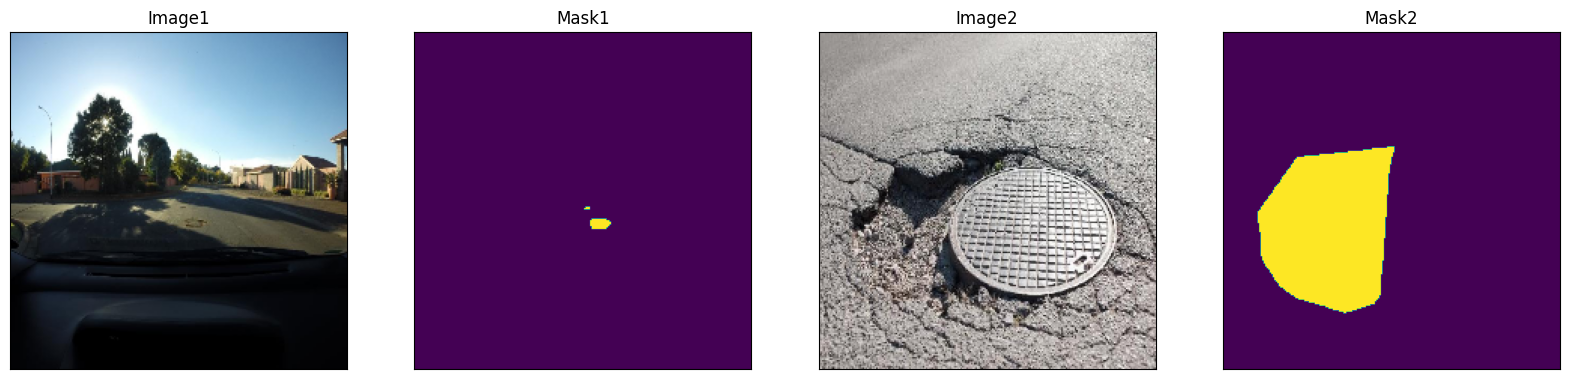

In [11]:
idx1, idx2 = np.random.randint(1,800), np.random.randint(1,800)
img, mask = pothole_Dataset[idx1]
img2, mask2 = pothole_Dataset[idx2]
print("Img:", img.shape)
print("Mask:", mask.shape)
print("Max Value Img:",img.max())
print("Max Value Mask: {} | Unique Value Mask: {}".format(mask.max(), mask.unique()))

visualize(
    image1=img.permute(1,2,0),
    mask1=mask.squeeze(),
    image2 = img2.permute(1,2,0),
    mask2 = mask2.squeeze(),
)

### Custom Metrics

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def step_learning_rate(base_lr, epoch, step_epoch, multiplier=0.1):
    """Sets the learning rate to the base LR decayed by 10 every step epochs"""
    lr = base_lr * (multiplier ** (epoch // step_epoch))
    return lr

### 4) Traning Model

#### 4.1) Define Transform

In [13]:
# transform_size = 257
#Define trainform to images
def img_transform(trainsize= 256):
    train_transform = A.Compose([
    A.Rotate([-10,10]),
    A.RandomScale([0.5,2]),
    A.GaussianBlur(),
    A.HorizontalFlip(),
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(width=trainsize, height=trainsize),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(),
    ])
    return train_transform, test_transform

#### 4.2) EarlyStopping

In [14]:
import copy

#patience, min_delta, restore_best_weights, best_model, best_loss counter status
#copy.deepcopy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stop on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

#### 4.3) Traning fuction and Eval Fuction

In [15]:
# Training fuction
def train(model,train_dataloader,device,optimizer, epoch, EPOCHS, writer, train_loss_meter, criterion):
    model.train()
    train_progress= tqdm(train_dataloader, colour="cyan")

    for idx, img_mask in enumerate(train_progress):
        img = img_mask[0].float().to(device) #img - B,C,H,W
        mask = img_mask[1].long().to(device) #label - B,H,W
        y_pred = model(img) #B,1, H, W
        y_pred = y_pred.squeeze() #B H W

        #Optimizer
        optimizer.zero_grad()

        loss = criterion(y_pred, mask)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())

        # tracking the loss function
        writer.add_scalar("Train/Loss", train_loss_meter.avg, epoch*len(train_dataloader)+idx)

        train_progress.set_description("TRAIN| Epoch: {}/{}| Iter: {}/{} | Loss: {:0.4f} | lr: {}".format(
            epoch+1, EPOCHS, idx+1, len(train_dataloader), loss, optimizer.param_groups[0]['lr']))

In [16]:
# Evaluate function
def evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter):

    model.eval()
    with torch.no_grad():
        for idx, img_mask in enumerate(val_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device) #B W H

            y_pred = model(img) #B, 1, H, W
            y_pred = y_pred.squeeze() #B H W

            y_pred[y_pred>0]=1 #BWH
            y_pred[y_pred<0]=0 #BWH

            intersection, union, target = intersectionAndUnionGPU(y_pred.float(), mask.float(), num_classes)
            intersection, union, target = intersection.cpu().numpy(), union.cpu().numpy(), target.cpu().numpy()
            intersection_meter.update(intersection), union_meter.update(union), target_meter.update(target)

            if idx>40: break

        #compute acc, iou, dice
        accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
        macc = np.mean(accuracy_class)
        miou = np.mean(iou_class) #mean vector 21D
        mdice = np.mean(dice_class) #mean vector 21D

    return macc, miou, mdice

#### 4.4) Traning Deeplabv3 ++ Model

In [17]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

from collections import OrderedDict
import segmentation_models_pytorch as smp
import shutil
from tqdm import tqdm

def main(learning_rate, batch_size, epochs, num_workers, data_path, model_save_path, tensorboard_path, num_classes, checkpoint_path):

    # Create model save directory if it doesn't exist
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    # Creater tensorboard directory
    if os.path.isdir(tensorboard_path):
        shutil.rmtree(tensorboard_path)
    os.mkdir(tensorboard_path)


    # Data augmentation and preprocessing for training and testing
    train_transform, test_transform = img_transform()

    # Create datasets and dataloaders
    train_dataset = PotholeDataset(image_set="train", transform=train_transform)
    test_dataset = PotholeDataset(image_set="valid", transform=test_transform)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model and move it to the appropriate device
    model = smp.DeepLabV3Plus(encoder_name="resnext101_32x8d",encoder_weights="imagenet",in_channels=3,classes= num_classes).to(device)

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = smp.losses.SoftBCEWithLogitsLoss(ignore_index=-100, reduction='mean', smooth_factor=0.05)

    # Best validation IoU for saving the best model
    best_predict = -1
    current_epoch = 0


    # Metrics
    train_loss_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()

    # Early Stop
    es = EarlyStopping(patience=14,restore_best_weights=False)

    # set up learning rate scheduler
    scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold= 1e-4, min_lr=0)

    # difine Tensorboard
    writer = SummaryWriter(tensorboard_path)


    # Training loop
    for epoch in range(current_epoch,epochs): #EPOCHS
        train_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()

        train(model,train_dataloader,device,optimizer, epoch, epochs, writer, train_loss_meter,criterion)
        acc, miou, dice = evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter)

        # write in tensorboard
        writer.add_scalar("Test/Acc", acc, epoch)
        writer.add_scalar("Test/mIOU", miou, epoch)
        writer.add_scalar("Test/Dice", dice, epoch)

        # update learning rate
        scheduler.step(1-miou)

        #Create checkpoint
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch,
            "optimizer_state_dict": optimizer.state_dict(),
            "dice": dice
        }

        # Save last checkpoint
        torch.save(checkpoint, os.path.join(model_save_path, "last.h5"))

        # Save best checkpoint based on dice score
        if dice > best_predict:
            torch.save(checkpoint, os.path.join(model_save_path, "best.h5"))
            best_predict = dice

        if es(model, 1-miou):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        print("VAL| Acc:{:0.4f}  | mIOU: {:0.4f} | Dice: {:0.4f} | EStop: {}".format(
             acc, miou, dice, es.status))

In [ ]:
if __name__ == '__main__':
    # Hyperparameters and paths
    learning_rate = 1e-4
    batch_size = 24
    epochs = 50
    num_workers = os.cpu_count()
    data_path = "data"
    model_save_path = "/content/Potholes-Detection-3trained_model"
    tensorboard_path = "/content/Potholes-Detection-3/tensorboard"
    num_classes = 1

    main(learning_rate,batch_size,epochs,num_workers,data_path,model_save_path,
        tensorboard_path,num_classes,model_save_path)
    pass

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:01<00:00, 239MB/s]
TRAIN| Epoch: 1/50| Iter: 1/34 | Loss: 0.7960 | lr: 0.0001:   3%|▎         | 1/34 [02:07<1:10:04, 127.41s/it]

### 5) Inference

#### 5.1) Create UnNormalize Fuction

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

#### 5.2) Create Prediction Show Images

In [ ]:
def pred_show_image_grid(model_pth, device, test_transform, num_classes, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    model = smp.DeepLabV3Plus(encoder_name="resnext101_32x8d",encoder_weights="imagenet",in_channels=3,classes= num_classes)

    # Load the updated state_dict into the model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    # Load validation dataset
    image_dataset = PotholeDataset(image_set="test", transform=test_transform)


    images, orig_masks, pred_masks = [], [], []
    with torch.no_grad():
        for i in range(num_imgs) :
            idx = np.random.randint(len(image_dataset))
            ori_img, mask = image_dataset[idx]
            img = ori_img
            img = img.to(device).float().unsqueeze(0)
            y_pred = model(img)

            y_pred = y_pred.squeeze() #B H W
            y_pred[y_pred>0]=1 #BWH
            y_pred[y_pred<0]=0 #BWH
            y_pred = y_pred.long()

            orig_masks.append(mask.cpu())
            pred_masks.append(y_pred.cpu())
            images.append(unorm(ori_img).permute(1, 2, 0))

    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)

    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

#### 5.3) Show Images

In [ ]:
# Define the transformation to be applied to the test images
_, test_transform = img_transform()

#Note: You must train the model before using this param
model_pth = "/kaggle/working/trained_model/last.h5"
num_classes=  1
device = "cuda" if torch.cuda.is_available() else "cpu"

#Show images
pred_show_image_grid(model_pth, device, test_transform, num_classes, num_imgs= 10)